# aSPEM Experiment : analysis




TODO: tester qu'à chaque pause, l'agent se réinitialise à $\hat{p}=.5$

In [1]:
%run 0_parameters.ipynb


WELCOME



In [2]:
import glob
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [4]:
msfigpath = '../PasturelMontagniniPerrinet2019/figures'

In [5]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

# find_h_with_MI

In [6]:
def r_(p, data) :
    
    p = np.ma.masked_array(p, mask=np.isnan(data)).compressed()
    data = np.ma.masked_array(data, mask=np.isnan(data)).compressed()

    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    
    return r_

In [7]:
def regress(ax, p, data, t_label=10, color='k', lw=2) :
    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    x_test = np.linspace(np.min(p), np.max(p), 100)
    fitLine = slope * x_test + intercept
    
    ax.plot(x_test, fitLine, c=color, linewidth=lw)

    x1, x2 = np.min(p), np.max(p)
    y1, y2 = np.min(data), np.max(data)
    
    #x_pos=x2-(x2-x1)/10 ; h_pos='right'
    #x_pos=x1+(x2-x1)/10 ; h_pos='left'
    #y_pos_r=y2-(y2-y1)/10 ; y_pos_m=y2-2*(y2-y1)/10
    y_pos_r=y1+(y2-y1)/10 ; y_pos_m=y1+2*(y2-y1)/10

    
    ax.text(x2, y_pos_r, 'r = %0.3f'%(r_), color=color, fontsize=t_label/1.2, ha='right')
    
    return ax


In [8]:
# https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#Weighted_correlation_coefficient
# https://stackoverflow.com/questions/38641691/weighted-correlation-coefficient-with-pandas
def r_weight(ax, x, y, w, t_label=10, color='k', lw=2) :
    
    x = np.ma.masked_array(x, mask=np.isnan(y)).compressed()
    y = np.ma.masked_array(y, mask=np.isnan(y)).compressed()
    
    def m(x, w):
        """Weighted Mean"""
        return np.sum(x * w) / np.sum(w)

    def cov(x, y, w):
        """Weighted Covariance"""
        return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

    def corr(x, y, w):
        """Weighted Correlation"""
        return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))    

    r = corr(x, y, w)
    
    x1, x2 = np.min(x), np.max(x)
    y1, y2 = np.min(y), np.max(y)
    
    #x_pos=x2-(x2-x1)/10 ; h_pos='right'
    #x_pos=x1+(x2-x1)/10 ; h_pos='left'
    #y_pos_r=y2-(y2-y1)/10 ; y_pos_m=y2-2*(y2-y1)/10
    y_pos_r=y1+(y2-y1)/10 ; y_pos_m=y1+2*(y2-y1)/10

    ax.text(x1, y_pos_r, 'r weight = %0.3f'%(r), color=color, fontsize=t_label/1.2, ha='left')
    
    return ax


YK OP SR CS FM AM LB IP DC BMC TN RS 

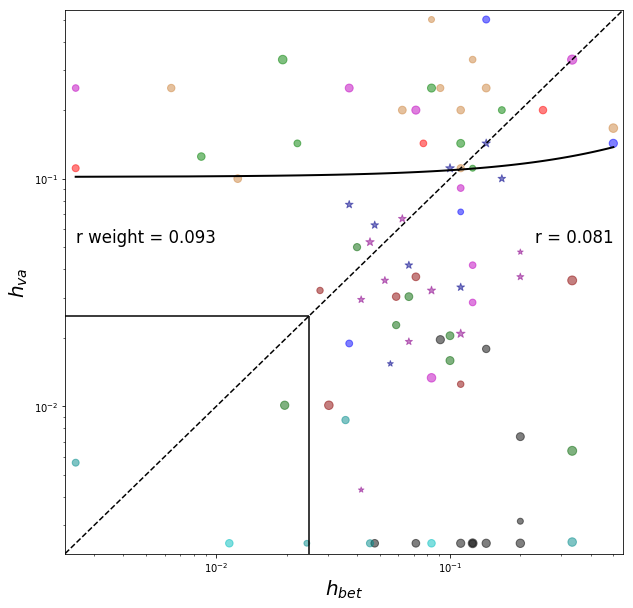

In [9]:
fig, ax = plt.subplots(1,1,figsize=(10,10))


Full = e.Full_list(modes_bcp=[])
modes_bcp = 'mean'
#list_h = np.geomspace(0.0025, 0.25, 1000)# 21)
#list_h = np.geomspace(0.001, 0.5, 100)# 21)
tau = np.arange(2, 401, 1)
list_h = 1/tau
#print(h)

COLOR = ['b', 'r', 'k', 'g', 'm', 'c',
         'darkblue', 'darkred', 'peru', 'darkgreen', 'darkmagenta', 'darkcyan']


h_va_full, h_bet_full = [], []
r_va_full, r_bet_full = [], []

for num, s in enumerate(set(Full.sujet)) :
    print(s, end=' ')
    va = Full['va'][Full.sujet==s].values.tolist()
    bet = Full['results'][Full.sujet==s].values.tolist()
    x = np.array(Full['bino'][Full.sujet==s].values.tolist())

    r_va_100, r_bet_100 = [], []
    for c in range(0, 3*200-50, 50) : r_va_100.append([]) ; r_bet_100.append([])

    for h in list_h :

        for d, c in enumerate(range(0, 3*200-50, 50)) :
            x_100 = x[c:c+100]
            p_hat_100 = np.zeros(100)

            liste = [0, 50, 100]
            for a in range(len(liste)-1) :
                p_bar, r_bar, beliefs = bcp.inference(x_100[liste[a]:liste[a+1]], h=h, p0=.5, r0=1.)
                p_hat_p, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=modes_bcp, p0=.5, fixed_window_size=40)
                p_hat_100[liste[a]:liste[a+1]] = p_hat_p
            r_va_100[d].append(r_(p_hat_100.tolist(), va[c:c+100]))
            r_bet_100[d].append(r_(p_hat_100.tolist(), bet[c:c+100]))

    h_va_100, h_bet_100 = [], []
    r_va, r_bet = [], []
    for d, c in enumerate(range(0, 3*200-50, 50)) :
        h_va_100.append(list_h[np.argmax(r_va_100[d])] if np.max(r_va_100[d]) > 0.55 else np.nan)
        h_bet_100.append(list_h[np.argmax(r_bet_100[d])] if np.max(r_bet_100[d]) > 0.55 else np.nan)
        
        r_va.append(np.max(r_va_100[d])) ; r_bet.append(np.max(r_bet_100[d]))
        
    #print('\nBet :\nh=', h_bet_100[:4], '\nr=', r_bet[:4], '\n\nva :\nh=', h_va_100[:4], '\nr=', r_va[:4], end='\n\n\n')
    ax.scatter(h_va_100, h_bet_100, c=COLOR[num], alpha=0.5, s=(np.array(r_va)*np.array(r_bet))*100,
               marker='*' if s in ['TN', 'LB'] else None)
    
    h_va_full.extend(h_va_100) ; h_bet_full.extend(h_bet_100)
    r_va_full.extend(r_va)     ; r_bet_full.extend(r_bet)

    
h_va_full = np.ma.masked_array(h_va_full, mask=np.isnan(h_bet_full)).compressed()
r_va_full = np.ma.masked_array(r_va_full, mask=np.isnan(h_bet_full)).compressed()
r_bet_full = np.ma.masked_array(r_bet_full, mask=np.isnan(h_bet_full)).compressed()
h_bet_full = np.ma.masked_array(h_bet_full, mask=np.isnan(h_bet_full)).compressed()

h_bet_full = np.ma.masked_array(h_bet_full, mask=np.isnan(h_va_full)).compressed()
r_bet_full = np.ma.masked_array(r_bet_full, mask=np.isnan(h_va_full)).compressed()
r_va_full = np.ma.masked_array(r_va_full, mask=np.isnan(h_va_full)).compressed()
h_va_full = np.ma.masked_array(h_va_full, mask=np.isnan(h_va_full)).compressed()

r_va_full = np.array(r_va_full)
r_bet_full = np.array(r_bet_full)


ax = regress(ax, h_bet_full, h_va_full, t_label=20, color='k', lw=2)
ax = r_weight(ax, h_bet_full, h_va_full, r_va_full*r_bet_full, t_label=20, color='k', lw=2)

ax.plot(np.arange(-10,10), np.arange(-10,10), '--k')
ax.vlines(0.025, 0, 0.025, colors='k')
ax.hlines(0.025, 0, 0.025, colors='k')
    
ax.set_xlabel('$h_{bet}$', fontsize=20) ; ax.set_xlim(min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
ax.set_ylabel('$h_{va}$', fontsize=20)  ; ax.set_ylim(min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
ax.set_xscale("log") ; ax.set_yscale("log")
plt.show()

In [10]:
for ext in exts: fig.savefig('{msfigpath}/5_inter-individual_differences_fit'.format(msfigpath=msfigpath) + ext, dpi=dpi)